In [1]:
import cPickle as pickle
import matplotlib.pylab as pl
%matplotlib inline
import mxnet as mx
import numpy as np
import mx_layers as layers
from data_utilities import load_mnist
from symbolic_gradient import _filter_arguments

In [2]:
_, _, _, _, original_X, original_Y = load_mnist(path='stretched_mnist', shape=(1, 56, 56))
_, _, _, _, shrinked_X, shrinked_Y = load_mnist(path='stretched_canvas_mnist', shape=(1, 56, 56))

In [3]:
def _normalized_convolution(**args):
  network = layers.convolution(**args)
  network = layers.batch_normalization(network)
  network = layers.ReLU(network)
  return network

In [4]:
network = layers.variable('data')
network = _normalized_convolution(X=network, n_filters=16, kernel_shape=(5, 5), stride=(1, 1), pad=(2, 2))
# network = layers.pooling(X=network, mode='maximum', kernel_shape=(2, 2), stride=(2, 2), pad=(0, 0))
# network = _normalized_convolution(X=network, n_filters=16, kernel_shape=(5, 5), stride=(1, 1), pad=(2, 2))
# network = layers.pooling(X=network, mode='maximum', kernel_shape=(2, 2), stride=(2, 2), pad=(0, 0))

In [5]:
N_LAYERS = 5
accuracy, _ = pickle.load(open('info/shrinked-mnist-plain-network-%d-no-pooling' % N_LAYERS, 'rb'))
parameters, states = pickle.load(open('parameters/shrinked-mnist-plain-network-%d-no-pooling' % N_LAYERS, 'rb'))

In [6]:
accuracy

0.11385350318471338

In [7]:
N = 100
context = mx.context.Context('cpu')
parameter_values, state_values = _filter_arguments(network, parameters, states)
parameter_values['data'] = shrinked_X[:N]
for key, value in parameter_values.items():
    parameter_values[key] = mx.nd.array(value, context)
for key, value in state_values.items():
    state_values[key] = mx.nd.array(value, context)

In [8]:
executor = network.bind(context, parameter_values, aux_states=state_values)
output = executor.forward()[0]
shrinked_feature_map = output.asnumpy()

In [9]:
parameter_values['data'] = mx.nd.array(original_X[:N], context)
executor = network.bind(context, parameter_values, aux_states=state_values)
output = executor.forward()[0]
original_feature_map = output.asnumpy()

In [10]:
N, C, W, H = shrinked_feature_map.shape
shrinked_feature_map = np.sum(np.abs(shrinked_feature_map), axis=1).reshape((N, W, H))
original_feature_map = np.sum(np.abs(original_feature_map), axis=1).reshape((N, W, H))

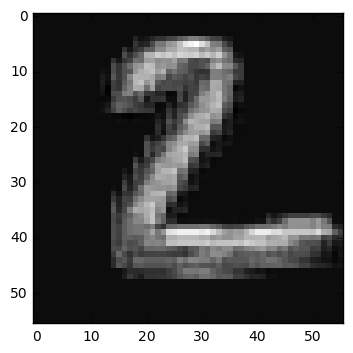

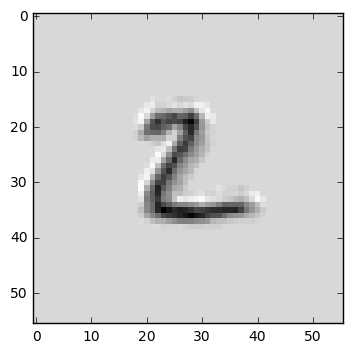

In [12]:
INDEX = 1
pl.figure()
pl.imshow(original_feature_map[INDEX], cmap='gray', interpolation='none')
pl.figure()
pl.imshow(shrinked_feature_map[INDEX], cmap='gray', interpolation='none')